## Exploratory Data Analysis of datasets

In [2]:
# import packages
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

### SQuAD2.0 dataset

In [60]:
# Import SQuAD2.0 train and dev sets seperately directly from the specified path

def load_squad_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        squad_dict = json.load(f)

    data = []
    for article in squad_dict['data']:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question = qa['question']
                qid = qa['id']
                is_impossible = qa.get('is_impossible', False)

                if is_impossible:
                    answers = []
                else:
                    answers = [ans['text'] for ans in qa['answers']]

                data.append({
                    'id': qid,
                    'question': question,
                    'context': context,
                    'answers': answers,
                    'is_impossible': is_impossible
                })

    return pd.DataFrame(data)

# File paths
train_file = 'data/SQuAD2/SQuAD2_train-v2.0.json'
dev_file = 'data/SQuAD2/SQuAD2_dev-v2.0.json'

# Load datasets
train_df = load_squad_dataset(train_file)
dev_df = load_squad_dataset(dev_file)

# Save to CSV files
train_df.to_csv('data/SQuAD2/SQuAD2_train.csv', index=False)
dev_df.to_csv('data/SQuAD2/SQuAD2_dev.csv', index=False)

# Display sample
print(train_df.head())

                         id  \
0  56be85543aeaaa14008c9063   
1  56be85543aeaaa14008c9065   
2  56be85543aeaaa14008c9066   
3  56bf6b0f3aeaaa14008c9601   
4  56bf6b0f3aeaaa14008c9602   

                                            question  \
0           When did Beyonce start becoming popular?   
1  What areas did Beyonce compete in when she was...   
2  When did Beyonce leave Destiny's Child and bec...   
3      In what city and state did Beyonce  grow up?    
4         In which decade did Beyonce become famous?   

                                             context                answers  \
0  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...    [in the late 1990s]   
1  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...  [singing and dancing]   
2  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...                 [2003]   
3  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...       [Houston, Texas]   
4  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...           [late 1990s]   

 

Saved dataset summary to tables/SQuAD/squad2_summary_stats.csv


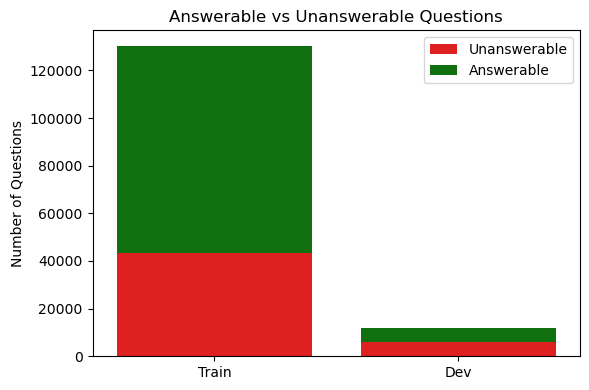

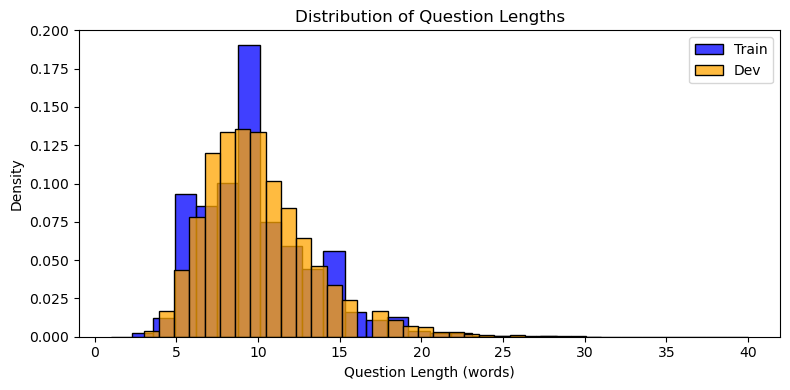

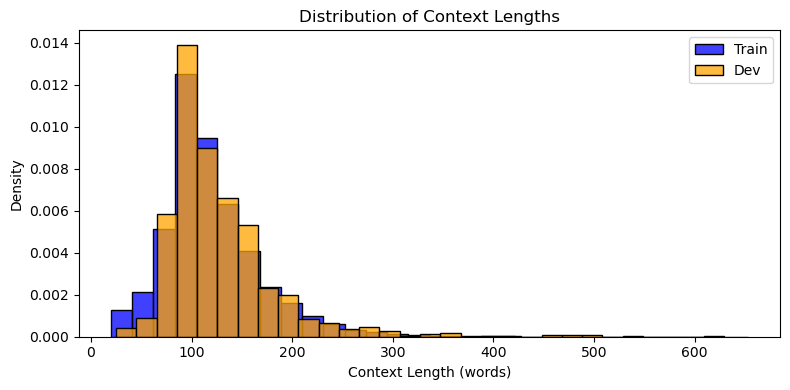

  Dataset  Total Questions  Answerable Questions  Unanswerable Questions  \
0   Train           130319                 86821                   43498   
1     Dev            11873                  5928                    5945   

   Avg Answers per Answerable Question  Avg Question Length (words)  \
0                             1.000000                     9.893822   
1                             3.424764                    10.019624   

   Avg Context Length (words)  
0                  119.614316  
1                  127.907184  


In [61]:
# Create output folders if they don't exist
os.makedirs("figures/SQuAD", exist_ok=True)
os.makedirs("tables/SQuAD", exist_ok=True)

# Function to compute dataset stats
def compute_stats(df, name):
    total_questions = len(df)
    unanswerable_count = df['is_impossible'].sum()
    answerable_count = total_questions - unanswerable_count
    avg_answers_per_question = df[df['is_impossible'] == False]['answers'].apply(len).mean()
    avg_question_length = df['question'].apply(lambda x: len(x.split())).mean()
    avg_context_length = df['context'].apply(lambda x: len(x.split())).mean()

    return {
        'Dataset': name,
        'Total Questions': total_questions,
        'Answerable Questions': answerable_count,
        'Unanswerable Questions': unanswerable_count,
        'Avg Answers per Answerable Question': avg_answers_per_question,
        'Avg Question Length (words)': avg_question_length,
        'Avg Context Length (words)': avg_context_length
    }

# Compute stats
train_stats = compute_stats(train_df, "Train")
dev_stats = compute_stats(dev_df, "Dev")
stats_df = pd.DataFrame([train_stats, dev_stats])

# Save stats table
stats_df.to_csv("tables/SQuAD/squad2_summary_stats.csv", index=False)
print("Saved dataset summary to tables/SQuAD/squad2_summary_stats.csv")

# ----------- Visualization 1: Answerable vs Unanswerable ------------
plt.figure(figsize=(6, 4))
sns.barplot(x=["Train", "Dev"],
            y=[train_stats['Unanswerable Questions'], dev_stats['Unanswerable Questions']],
            color="red", label="Unanswerable")
sns.barplot(x=["Train", "Dev"],
            y=[train_stats['Answerable Questions'], dev_stats['Answerable Questions']],
            color="green",
            bottom=[train_stats['Unanswerable Questions'], dev_stats['Unanswerable Questions']],
            label="Answerable")
plt.ylabel("Number of Questions")
plt.title("Answerable vs Unanswerable Questions")
plt.legend()
plt.tight_layout()
plt.savefig("figures/SQuAD/answerable_vs_unanswerable.png")
plt.show()

# ----------- Visualization 2: Question Length Distribution ------------
plt.figure(figsize=(8, 4))
sns.histplot(train_df['question'].apply(lambda x: len(x.split())), kde=False, bins=30, label='Train', color='blue', stat="density")
sns.histplot(dev_df['question'].apply(lambda x: len(x.split())), kde=False, bins=30, label='Dev', color='orange', stat="density")
plt.xlabel("Question Length (words)")
plt.ylabel("Density")
plt.title("Distribution of Question Lengths")
plt.legend()
plt.tight_layout()
plt.savefig("figures/SQuAD/question_length_distribution.png")
plt.show()

# ----------- Visualization 3: Context Length Distribution ------------
plt.figure(figsize=(8, 4))
sns.histplot(train_df['context'].apply(lambda x: len(x.split())), kde=False, bins=30, label='Train', color='blue', stat="density")
sns.histplot(dev_df['context'].apply(lambda x: len(x.split())), kde=False, bins=30, label='Dev', color='orange', stat="density")
plt.xlabel("Context Length (words)")
plt.ylabel("Density")
plt.title("Distribution of Context Lengths")
plt.legend()
plt.tight_layout()
plt.savefig("figures/SQuAD/context_length_distribution.png")
plt.show()

print(stats_df)

In [25]:
# --- Create example instance table ---
example = train_df[train_df['answers'].apply(lambda x: len(x) > 0)].iloc[0]
example_table = pd.DataFrame({
    "Title": ["N/A (SQuAD 2.0)"],
    "Context": [example['context']],
    "Question": [example['question']],
    "Answer": [example['answers'][0]]
})

example_table.to_csv("tables/SQuAD/squad2_example_instance.csv", index=False)

In [26]:
example_table

,Title,Context,Question,Answer
0,N/A (SQuAD 2.0),Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s


In [37]:
# Concatenate text of all rows in each column
all_context_text = ' '.join(train_df["context"].tolist())
all_question_text = ' '.join(train_df["question"].tolist())
all_answer_text = ' '.join(train_df["answers"].apply(lambda x: ' '.join(x)).tolist())

# Calculate word frequency using Counter
context_word_freq = Counter(all_context_text.split())
question_word_freq = Counter(all_question_text.split())
answer_word_freq = Counter(all_answer_text.split())

# Get the top 15 most frequent words for each column
top_context_words = dict(context_word_freq.most_common(15))
top_question_words = dict(question_word_freq.most_common(15))
top_answer_words = dict(answer_word_freq.most_common(15))

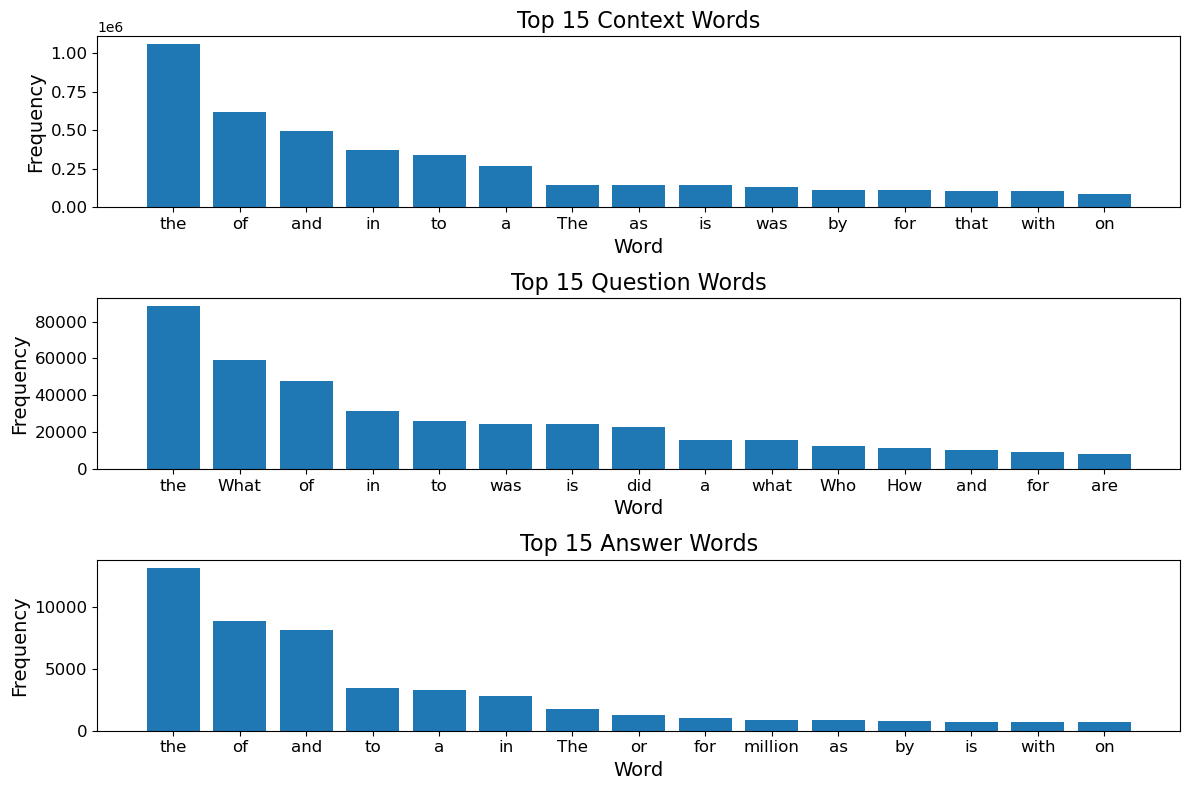

In [39]:
# Plot bar plots
fig, axs = plt.subplots(3, 1, figsize=(12, 8))

axs[0].bar(top_context_words.keys(), top_context_words.values())
axs[0].set_title("Top 15 Context Words", fontsize=16)
axs[0].set_xlabel("Word", fontsize=14)
axs[0].set_ylabel("Frequency", fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=12)

axs[1].bar(top_question_words.keys(), top_question_words.values())
axs[1].set_title("Top 15 Question Words", fontsize=16)
axs[1].set_xlabel("Word", fontsize=14)
axs[1].set_ylabel("Frequency", fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=12)

axs[2].bar(top_answer_words.keys(), top_answer_words.values())
axs[2].set_title("Top 15 Answer Words", fontsize=16)
axs[2].set_xlabel("Word", fontsize=14)
axs[2].set_ylabel("Frequency", fontsize=14)
axs[2].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig("figures/SQuAD/train_word_frequency")
plt.show()

In [31]:
# Function to generate word cloud from word frequency and save the plot
def generate_wordcloud_and_save(word_freq, filename):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(f"figures/SQuAD/{filename}")
    plt.close()
    plt.show()

# Generate word clouds and save plots
generate_wordcloud_and_save(context_word_freq, "context_wordcloud.png")
generate_wordcloud_and_save(question_word_freq, "question_wordcloud.png")

### TriviaQA

In [13]:
dev_df_trivia['answers']

0                           [David Seville, david seville]
1        [scorpio, Scorpio (disambiguation), Skorpio, s...
2        [Sunset Bulevard, sunset blvd, Sunset Blvd, Su...
3        [sir henry campbell bannerman, Sir Henry Campb...
4        [internal exile, exile and banishment, Forced ...
                               ...                        
11308             [The grinch, The Grinch, Grinch, grinch]
11309    [Uncle Crimbo, christmas feast, christmas them...
11310    [brownness, Brown, Blackishoranges, list of te...
11311    [Frosty the Snowman (song), Frosty the Snowman...
11312    [Horse shoes, horseshoe pitching, horseshoe pi...
Name: answers, Length: 11313, dtype: object

In [10]:
df_trivia['answers'].apply(lambda x: len(x) > 0)

0        True
1        True
2        True
3        True
4        True
         ... 
98930    True
98931    True
98932    True
98933    True
98934    True
Name: answers, Length: 98935, dtype: bool

In [14]:
def load_triviaqa_dataset(file_path):
    import json
    import pandas as pd

    with open(file_path, 'r', encoding='utf-8') as f:
        data_dict = json.load(f)

    data = []
    for item in data_dict.get('Data', []):
        # Defensive: check for each field, use None or empty if missing
        question = item.get('Question', None)
        question_id = item.get('QuestionId', None)
        question_source = item.get('QuestionSource', None)
        answers = []
        answer_dict = item.get('Answer', {})
        if isinstance(answer_dict, dict):
            if 'NormalizedValue' in answer_dict and answer_dict['NormalizedValue']:
                answers.append(answer_dict['NormalizedValue'])
            if 'Aliases' in answer_dict and answer_dict['Aliases']:
                answers.extend(answer_dict['Aliases'])
            if 'NormalizedAliases' in answer_dict and answer_dict['NormalizedAliases']:
                answers.extend(answer_dict['NormalizedAliases'])
        # Remove duplicates and empty strings
        answers = list(set(filter(None, answers)))
        data.append({
            'question': question,
            'question_id': question_id,
            'question_source': question_source,
            'answers': answers
        })
    df = pd.DataFrame(data)
    df['answers'] = df['answers'].apply(lambda x: list(set(filter(None, x))))
    return df

# File paths
train_file = 'data/triviaqa-unfiltered/unfiltered-web-train.json'
dev_file = 'data/triviaqa-unfiltered/unfiltered-web-dev.json'

# Load datasets
train_df_trivia = load_triviaqa_dataset(train_file)
dev_df_trivia = load_triviaqa_dataset(dev_file)

# Merge dev and train into two datasets (with answers and without answers)
df_trivia = pd.concat([train_df_trivia, dev_df_trivia], ignore_index=True)

# Save to CSV files
df_trivia.to_csv('data/triviaqa-unfiltered/trivia_all.csv', index=False)

# Display sample and info
print("Training set info:")
print(df_trivia.info())
print("\nFirst few examples:")
print(df_trivia.head())

Training set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98935 entries, 0 to 98934
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   question         98935 non-null  object
 1   question_id      98935 non-null  object
 2   question_source  98935 non-null  object
 3   answers          98935 non-null  object
dtypes: object(4)
memory usage: 3.0+ MB
None

First few examples:
                                            question question_id  \
0  Who was President when the first Peanuts carto...        tc_0   
1  Which American-born Sinclair won the Nobel Pri...        tc_1   
2         Where in England was Dame Judi Dench born?        tc_3   
3  William Christensen of Madison, New Jersey, ha...        tc_4   
4  In which decade did Billboard magazine first p...        tc_5   

                 question_source  \
0  http://www.triviacountry.com/   
1  http://www.triviacountry.com/   
2  http://www.trivia

Dataset Statistics:
  Dataset  Total Questions  Avg Answers per Question  \
0   Train            87622                 24.846351   
1     Dev            11313                 25.408291   

   Avg Question Length (words)  
0                    13.988268  
1                    13.978167  


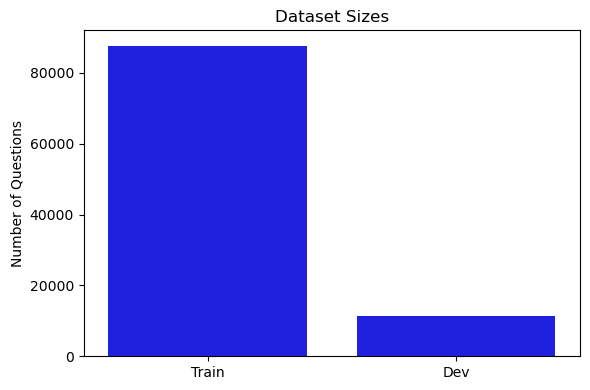

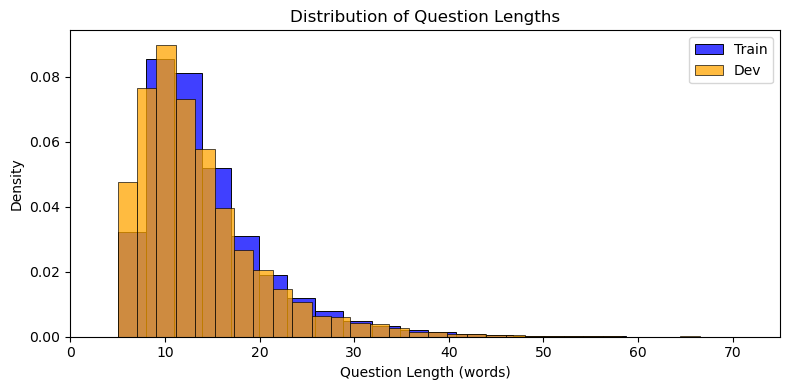

<Figure size 640x480 with 0 Axes>

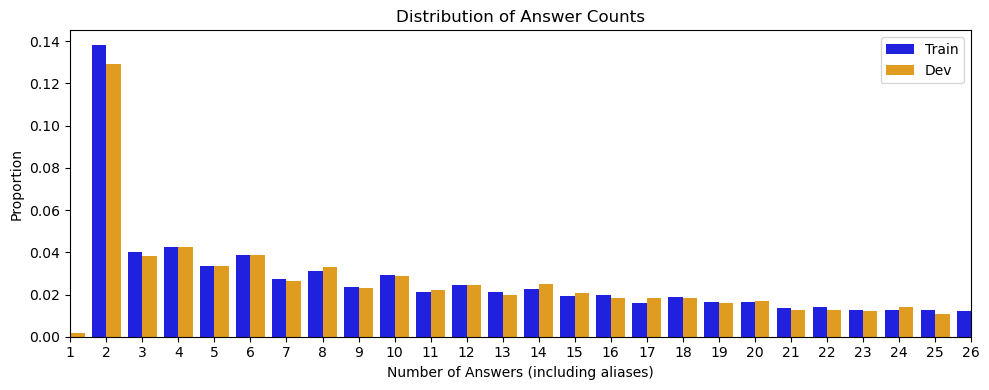

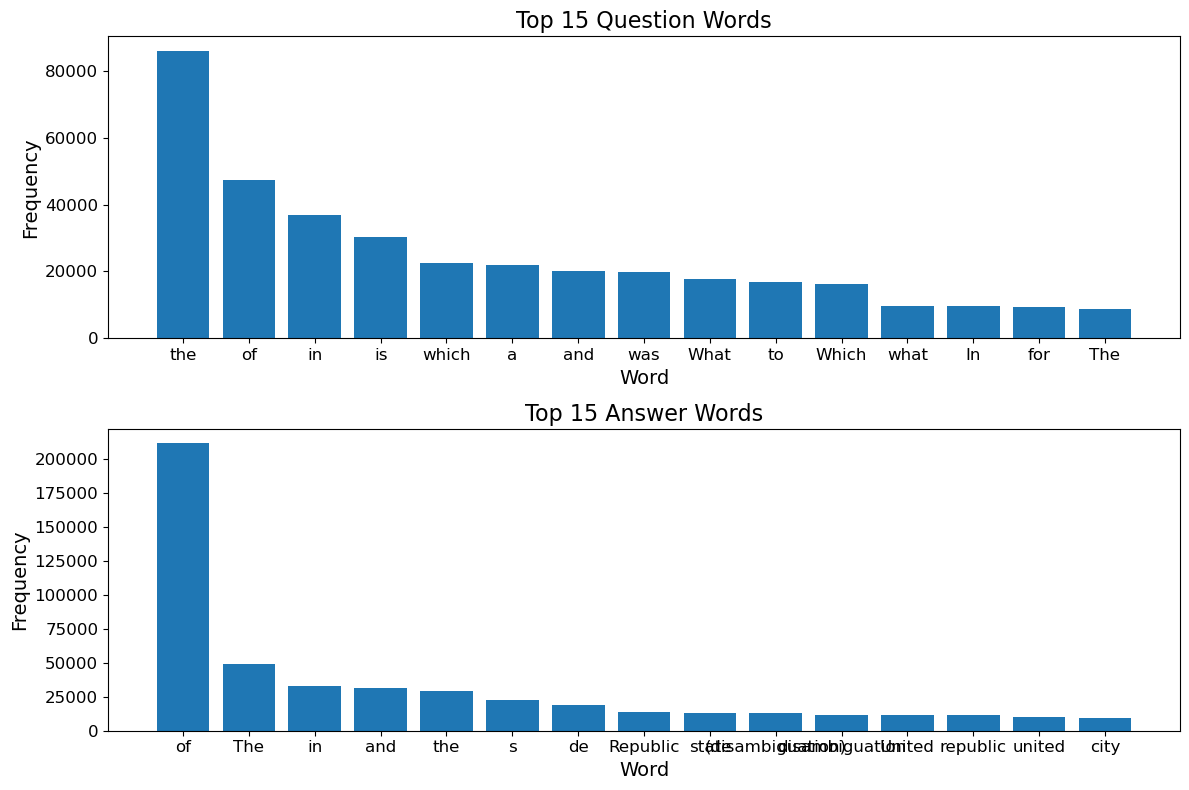


Example Instance:
                                            Question  \
0  Who was President when the first Peanuts carto...   

                                             Answers  
0  Mary Jane Truman, president truman, Mr. Citize...  


In [20]:
# Create output folders
os.makedirs("figures/TriviaQA", exist_ok=True)
os.makedirs("tables/TriviaQA", exist_ok=True)

# Compute dataset statistics
def compute_triviaqa_stats(df, name):
    total_questions = len(df)
    avg_answers_per_question = df['answers'].apply(len).mean()
    avg_question_length = df['question'].apply(lambda x: len(x.split())).mean()
    
    return {
        'Dataset': name,
        'Total Questions': total_questions,
        'Avg Answers per Question': avg_answers_per_question,
        'Avg Question Length (words)': avg_question_length,
    }

# Compute stats
train_stats = compute_triviaqa_stats(train_df_trivia, "Train")
dev_stats = compute_triviaqa_stats(dev_df_trivia, "Dev")
stats_df = pd.DataFrame([train_stats, dev_stats])

# Save stats table
stats_df.to_csv("tables/TriviaQA/triviaqa_summary_stats.csv", index=False)
print("Dataset Statistics:")
print(stats_df)

# Visualization 1: Dataset sizes
plt.figure(figsize=(6, 4))
sns.barplot(x=["Train", "Dev"],
            y=[train_stats['Total Questions'], dev_stats['Total Questions']],
            color="blue")
plt.ylabel("Number of Questions")
plt.title("Dataset Sizes")
plt.tight_layout()
plt.savefig("figures/TriviaQA/dataset_sizes.png")
plt.show()

# Visualization 2: Question Length Distribution
plt.figure(figsize=(8, 4))
sns.histplot(train_df_trivia['question'].apply(lambda x: len(x.split())), 
             kde=False, bins=60, label='Train', color='blue', stat="density")
sns.histplot(dev_df_trivia['question'].apply(lambda x: len(x.split())), 
             kde=False, bins=60, label='Dev', color='orange', stat="density")
plt.xlabel("Question Length (words)")
plt.ylabel("Density")
plt.xlim(0, 75)
plt.title("Distribution of Question Lengths")
plt.legend()
plt.tight_layout()
plt.savefig("figures/TriviaQA/question_length_distribution.png")
plt.show()

# Reset plots
plt.clf()

# Visualization 3: Number of Answers Distribution - using barplots
plt.figure(figsize=(10, 4))

# Count frequency of answers per question
train_answers_count = train_df_trivia['answers'].apply(len).value_counts().sort_index()
dev_answers_count = dev_df_trivia['answers'].apply(len).value_counts().sort_index()

# Get the union of all possible counts
all_counts = sorted(set(train_answers_count.index) | set(dev_answers_count.index))

# Create a dataframe for plotting
counts_data = pd.DataFrame({
    'Count': all_counts,
    'Train': [train_answers_count.get(c, 0) / len(train_df_trivia) for c in all_counts],
    'Dev': [dev_answers_count.get(c, 0) / len(dev_df_trivia) for c in all_counts]
})

# Reshape for seaborn
plot_data = counts_data.melt(id_vars=['Count'], 
                            var_name='Dataset', 
                            value_name='Proportion')

# Plot
sns.barplot(data=plot_data, x='Count', y='Proportion', hue='Dataset', 
            palette={'Train': 'blue', 'Dev': 'orange'})
plt.xlabel("Number of Answers (including aliases)")
plt.ylabel("Proportion")
plt.xlim(0, 25)  # Limit x-axis to 25 for better visibility
plt.title("Distribution of Answer Counts")
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.savefig("figures/TriviaQA/answer_count_distribution.png")
plt.show()

# Word frequency analysis
all_question_text = ' '.join(train_df_trivia["question"].tolist())
all_answer_text = ' '.join(train_df_trivia["answers"].apply(lambda x: ' '.join(x)).tolist())

question_word_freq = Counter(all_question_text.split())
answer_word_freq = Counter(all_answer_text.split())

# Get top 15 words
top_question_words = dict(question_word_freq.most_common(15))
top_answer_words = dict(answer_word_freq.most_common(15))

# Plot word frequencies
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.bar(top_question_words.keys(), top_question_words.values())
ax1.set_title("Top 15 Question Words", fontsize=16)
ax1.set_xlabel("Word", fontsize=14)
ax1.set_ylabel("Frequency", fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax2.bar(top_answer_words.keys(), top_answer_words.values())
ax2.set_title("Top 15 Answer Words", fontsize=16)
ax2.set_xlabel("Word", fontsize=14)
ax2.set_ylabel("Frequency", fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig("figures/TriviaQA/word_frequency.png")
plt.show()

# Generate and save word clouds
def generate_wordcloud_and_save(word_freq, filename):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(f"figures/TriviaQA/{filename}")
    plt.close()
    plt.show()

generate_wordcloud_and_save(question_word_freq, "question_wordcloud.png")
generate_wordcloud_and_save(answer_word_freq, "answer_wordcloud.png")

# Create example instance table
example = train_df_trivia.iloc[0]
example_table = pd.DataFrame({
    "Question": [example['question']],
    "Answers": [', '.join(example['answers'])]
})

example_table.to_csv("tables/TriviaQA/triviaqa_example_instance.csv", index=False)
print("\nExample Instance:")
print(example_table)